# Stability at the 12m tower

__Problem Statement__:
Stability is normally estimated using at most a handful of point observations. With DTS we can continuously define the gradient using very fine resolution temperature observations. What meteorological conditions impact the stability? Here we will investigate stability defined as $\frac{dT}{d\ln{z}}$ using the tower DTS Bayesian GLM with student's t-distribution priors for the DTS error.

__Goals of Notebook__:
- Understand which conditions lead to different classifications of stability.
- Understand how that varies with estimate type.
- Investigate the factors that contribute to the largest disagreements between CSAT observed sensible heat flux and the DTS observed stability.

DTS stability were estimated using a log-linear Bayes GLM assuming that errors were distributed as Student's t distributions. These inferences were made in `bayesian-GLM_estimate-dTdz.ipynb`

# 1. Import and formatting

In [1]:
# Data and methods libraries
import numpy as np
import xarray as xr
import scipy.stats
import pandas as pd

# OS interaction
import os

# import plotting
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import string
import datetime
import copy
import pymc3 as pm
import warnings

## Format plots

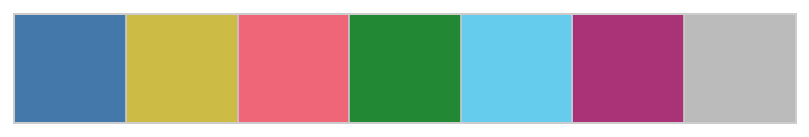

In [2]:
%matplotlib inline
# Higher resolution figures within the notebook
%config InlineBackend.figure_format = 'retina'

# Set the plot style from the seaborn library
sns.set_style("whitegrid")
context = 'paper'
sns.set_context(context)

# Tol bright color scheme reordered to put my favorite colors first
tol_bright_reorder = ['#4477AA', '#CCBB44', '#EE6677', '#228833', '#66CCEE', '#AA3377', '#BBBBBB']
sns.set_palette(sns.color_palette(tol_bright_reorder))
sns.palplot(tol_bright_reorder)

## Directories

In [3]:
dir_pre = os.path.join('/Users/karllapo/Dropbox/DarkMix/proj/DarkMix_Voitsumra/')

# Met data
dir_logger_data = os.path.join(dir_pre, 'logger_data')
dir_aws_data = os.path.join(dir_logger_data, 'AWS')
dir_csat_stats = os.path.join(dir_logger_data, 'CSATs', 'stats')
dir_csat_flux = os.path.join(dir_logger_data, 'CSATs', 'fluxes')
dir_csat_corr = os.path.join(dir_logger_data, 'CSATs', 'csat-Ts-correction')
dir_ceil = os.path.join(dir_pre, 'love_dts/ESSD-repository/remote-sensing/ceilometer/')
dir_press = os.path.join(dir_logger_data, 'pressure')
dir_bayes_glm = os.path.join(dir_pre, 'love_dts', 'bayes_glm')
dir_homogenized_data = os.path.join(dir_pre, 'homogenized_data')

# Figures
dir_print = os.path.join(dir_pre, 'figures', 'AncillaryMet')


# 2. Load data

## 2.1 Homogenized data

Use the homogenized data from `homogenizing-stability-data.ipynb`

In [4]:
os.chdir(dir_homogenized_data)

sonic_1min = xr.open_dataset('sonics_pot-temp_1min_qc_tower-subset.v1-2021-02-22.nc')
sonic_10min = xr.open_dataset('sonics_pot-temp_10min_qc_tower-subset.v1-2021-02-22.nc')
aws_2m_theta = xr.open_dataarray('aws_pot-temp_1min_qc_tower-subset.v1-2021-02-22.nc')
aws_2m_theta_10min = xr.open_dataarray('aws_pot-temp_10min_qc_tower-subset.v1-2021-02-22.nc')
tower = xr.open_dataset('tower_pot-temp_1s_qc_tower-subset.v1-2021-02-22.nc')
tower_1min = xr.open_dataset('tower_pot-temp_1min_qc_tower-subset.v1-2021-02-22.nc')


## 2.2 Tower 10min Bayesian modeling output

In [5]:
os.chdir(dir_bayes_glm)
tower_10min = xr.open_dataset('tower_10min_bayes_glm.nc')

## 2.2 Ceilometer, AWS, and pressure data

- Ceilometer for cloudiness
- AWS for radiation and RH
- pressure for potential temperature calculations

In [6]:
os.chdir(dir_ceil)
ceilo = xr.open_dataset('ceiolometer-combined-files_2019_June01-Aug15.nc')
ceilo = ceilo.reindex_like(sonic_1min.time, method='nearest')
ceilo_10min = ceilo.interp_like(tower_10min.time, method='nearest')

In [7]:
os.chdir(dir_aws_data)
aws_10min = xr.open_dataset('AWS_Voi_10min.nc')

## 2.3 Quickly estimate stability using the CSATs


In [8]:
sonic_10min['ols_m'] = (('time'), np.zeros(len(sonic_10min.time.values)))
sonic_10min['ols_r'] = (('time'), np.zeros(len(sonic_10min.time.values)))
sonic_10min['ols_p'] = (('time'), np.zeros(len(sonic_10min.time.values)))
sonic_10min['ols_b'] = (('time'), np.zeros(len(sonic_10min.time.values)))


In [9]:
for t in sonic_10min.time:
    ds = sonic_10min.sel(time=t).theta

    result_dts = scipy.stats.linregress(np.log(ds.z), ds.values)
    sonic_10min['ols_m'].loc[{'time': t}] = result_dts.slope
    sonic_10min['ols_r'].loc[{'time': t}] = result_dts.rvalue
    sonic_10min['ols_p'].loc[{'time': t}] = result_dts.pvalue
    sonic_10min['ols_b'].loc[{'time': t}] = result_dts.intercept

## 2.4 Create a gappy version of the 10min DTS tower data

In [10]:
dt = pd.date_range(
    start=pd.Timestamp(tower_10min.time[0].values),
    end=pd.Timestamp(tower_10min.time[-1].values),
    freq='10min',
)

tower_10min_nanfill = tower_10min.reindex(time=dt, tolerance=1, method='nearest')

Text(0, 0.5, 'Counts (-)')

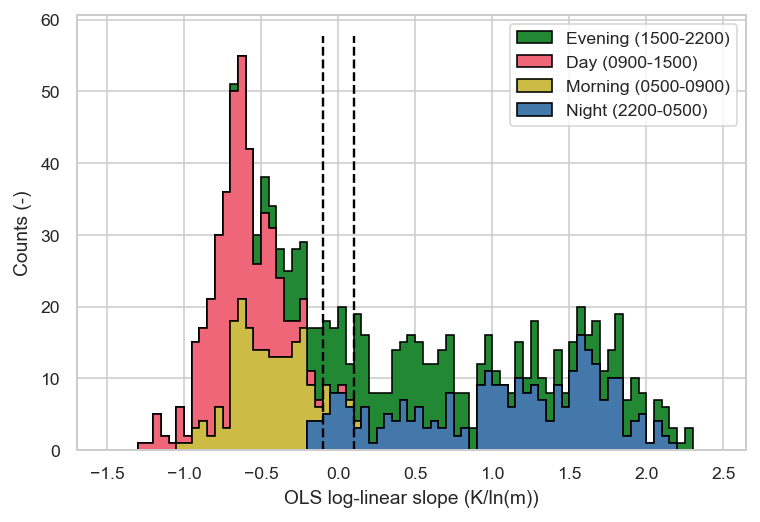

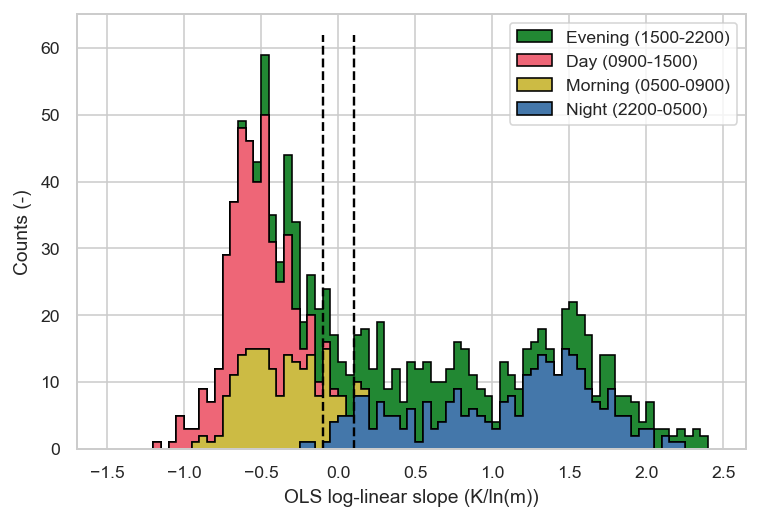

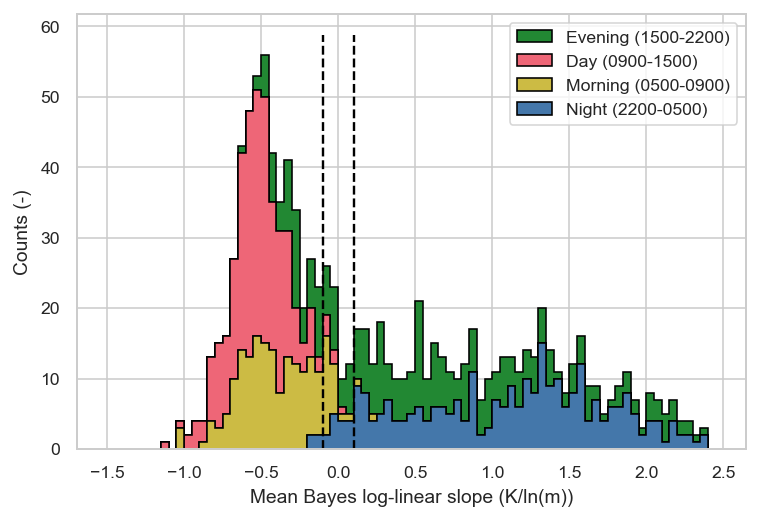

In [11]:
# OLS linear fit
plt.figure()
ds = sonic_10min.ols_m
plt.hist([
    ds.where((ds['time.hour'] < 5) | (ds['time.hour'] > 22)),
    ds.where((ds['time.hour'] >= 5) & (ds['time.hour'] < 9)),
    ds.where((ds['time.hour'] >= 9) & (ds['time.hour'] < 15)),
    ds.where((ds['time.hour'] >= 15) & (ds['time.hour'] < 22)),
    ], 
    np.arange(-1.5, 2.5, 0.05),
    stacked=True,
    histtype='stepfilled',
    label=[
        'Night (2200-0500)',
        'Morning (0500-0900)',
        'Day (0900-1500)',
        'Evening (1500-2200)',
    ],
    edgecolor='k'
);
plt.legend()
ymax = plt.gca().get_ylim()[-1]
plt.plot([-0.1, -0.1], [0, ymax], 'k--')
plt.plot([0.1, 0.1], [0, ymax], 'k--')
plt.gca().set_xlabel('OLS log-linear slope (K/ln(m))')
plt.gca().set_ylabel('Counts (-)')


# OLS linear fit
plt.figure()
ds = tower_10min.ols_m
plt.hist([
    ds.where((ds['time.hour'] < 5) | (ds['time.hour'] > 22)),
    ds.where((ds['time.hour'] >= 5) & (ds['time.hour'] < 9)),
    ds.where((ds['time.hour'] >= 9) & (ds['time.hour'] < 15)),
    ds.where((ds['time.hour'] >= 15) & (ds['time.hour'] < 22)),
    ], 
    np.arange(-1.5, 2.5, 0.05),
    stacked=True,
    histtype='stepfilled',
    label=[
        'Night (2200-0500)',
        'Morning (0500-0900)',
        'Day (0900-1500)',
        'Evening (1500-2200)',
    ],
    edgecolor='k',
);
plt.legend()
ymax = plt.gca().get_ylim()[-1]
plt.plot([-0.1, -0.1], [0, ymax], 'k--')
plt.plot([0.1, 0.1], [0, ymax], 'k--')
plt.gca().set_xlabel('OLS log-linear slope (K/ln(m))')
plt.gca().set_ylabel('Counts (-)')

# Student's t-distribution
plt.figure()
ds = tower_10min.b1_slope.mean(dim='draws')
plt.hist([
    ds.where((ds['time.hour'] < 5) | (ds['time.hour'] > 22)),
    ds.where((ds['time.hour'] >= 5) & (ds['time.hour'] < 9)),
    ds.where((ds['time.hour'] >= 9) & (ds['time.hour'] < 15)),
    ds.where((ds['time.hour'] >= 15) & (ds['time.hour'] < 22)),
    ], 
    np.arange(-1.5, 2.5, 0.05),
    stacked=True,
    histtype='stepfilled',
    label=[
        'Night (2200-0500)',
        'Morning (0500-0900)',
        'Day (0900-1500)',
        'Evening (1500-2200)',
    ],
    edgecolor='k',
);
plt.legend()
ymax = plt.gca().get_ylim()[-1]
plt.plot([-0.1, -0.1], [0, ymax], 'k--')
plt.plot([0.1, 0.1], [0, ymax], 'k--')
plt.gca().set_xlabel('Mean Bayes log-linear slope (K/ln(m))')
plt.gca().set_ylabel('Counts (-)')

### Visualizing the distribution of slopes during neutral conditions

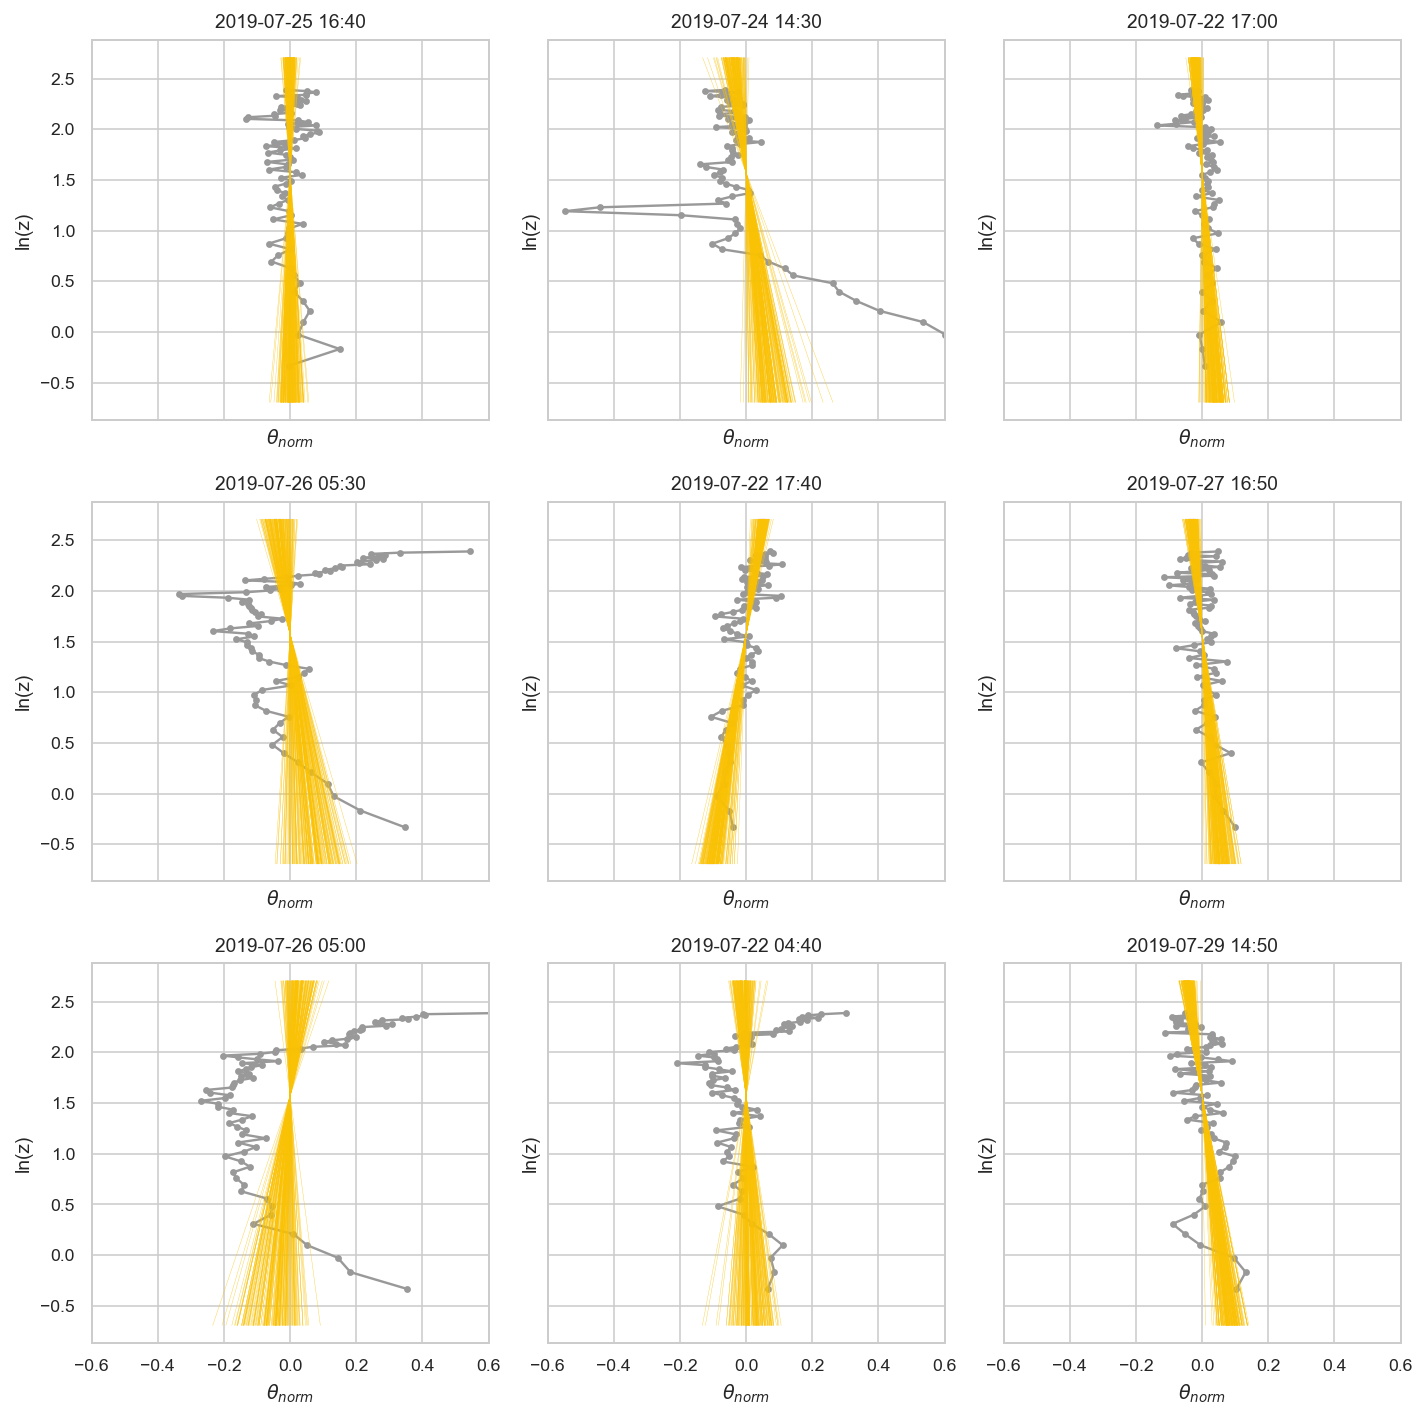

In [12]:
from numpy.random import default_rng

ind = (tower_10min.b1_slope.mean(dim='draws') < 0.05) & (tower_10min.b1_slope.mean(dim='draws') > -0.05)
ds = tower_10min.where(ind, drop=True)

rng = default_rng()
samp = rng.choice(len(ds.time.values), size=9, replace=False)

fig, axes = plt.subplots(3, 3, sharey=True, sharex=True, figsize=(10, 10))
axes = axes.flatten()

lm = lambda x, s: s["b0_intercept"].values + s["b1_slope"].values * x
lnz_eval = np.arange(np.log(0.5), np.log(15), 0.01)
lnz_normalize = ds.lnz.values
for ns, n in enumerate(samp):
    ax = axes[ns]
    dt = pd.Timestamp(ds.isel(time=n).time.values)
    ds_dt = ds.isel(time=n)
    y = ds_dt.lnz.values
    x = ds_dt.theta_mean_norm.values
    ax.plot(x, y, color='0.6', marker='.')

    for rand_loc in np.random.randint(0, len(tower_10min.draws), 200):
        rand_sample = ds.isel(time=n).isel(draws=rand_loc)
        ax.plot(
            lm(lnz_eval, rand_sample) - np.mean(lm(lnz_normalize, rand_sample)),
            lnz_eval,
            color='xkcd:goldenrod',
            alpha=0.8,
            lw=0.2,
        )
        
    ax.plot(
        ds.ols_b.isel(time=n).values + ds.ols_m.isel(time=n).values * lnz_eval,
        lnz_eval,
        color='k', lw=0.8, ls='--')
    
    ax.set_title(dt.strftime('%Y-%m-%d %H:%M'))
    ax.set_ylabel('ln(z)')
    ax.set_xlabel(r'$\theta_{norm}$')
    ax.set_xlim(-0.6, 0.6)
fig.tight_layout()

Periods with obvious sublayers are still fairly porrly fit. But in general this gives the results I would intuitively expect.

# 7. Pair plots

Next is to look at the join distributions of cloud cover, Qh, potential temperature, gradient slope (both DTS and sonic), wind speed, LWdwn, SWdwn, and LWnet.

## 7.1 prepare data

First, let's create a data label for each interval to use when labeling the pair plots.

In [14]:
ds = copy.deepcopy(tower_10min)
ds['interval'] = (('time'), np.zeros_like(ds.ols_m))
ds['interval'] = ds['interval'].where((ds['time.hour'] > 5) & (ds['time.hour'] <= 22), 'night')
ds['interval'] = ds['interval'].where((ds['time.hour'] < 5) | (ds['time.hour'] >= 9), 'morning')
ds['interval'] = ds['interval'].where((ds['time.hour'] < 9) | (ds['time.hour'] >= 15), 'day')
ds['interval'] = ds['interval'].where((ds['time.hour'] < 15) | (ds['time.hour'] > 22), 'evening')

Then convert everything to pandas.

In [15]:
# Create a merged Dataset.
# Previously I worked with just the 4m CSAT. Here I include all of them for additional
# investigation.
ds_10min = xr.merge(
    [
        sonic_10min.theta,
        sonic_10min.wTs,
        sonic_10min.U_scalar_mean_rot.rename('U_sonic'),
        tower_10min.b1_slope.mean(dim='draws'),
        ceilo_10min.tcc,
        aws_2m_theta_10min.rename('AWS_theta_2m'),
        aws_10min['Rlwd (CNR4)'].rename('LWdwn'),
        (aws_10min['Rlwd (CNR4)'] - aws_10min['Rlwu (CNR4)']).rename('LWnet'),
        aws_10min['Rswd (CNR4)'].rename('SWdwn'),
        ds['interval'],
    ],
)

df_10min = xr.Dataset.to_dataframe(
    ds_10min.drop(
        [
            'x', 'z', 'LAF',
            'northcones', 'unheated',
            'southcones', 'y',
            'heated', 'eastcones'
        ],
    errors='ignore',
    )
)

Most of the neutral conditions occur in the transition periods. Let's first visualize those.

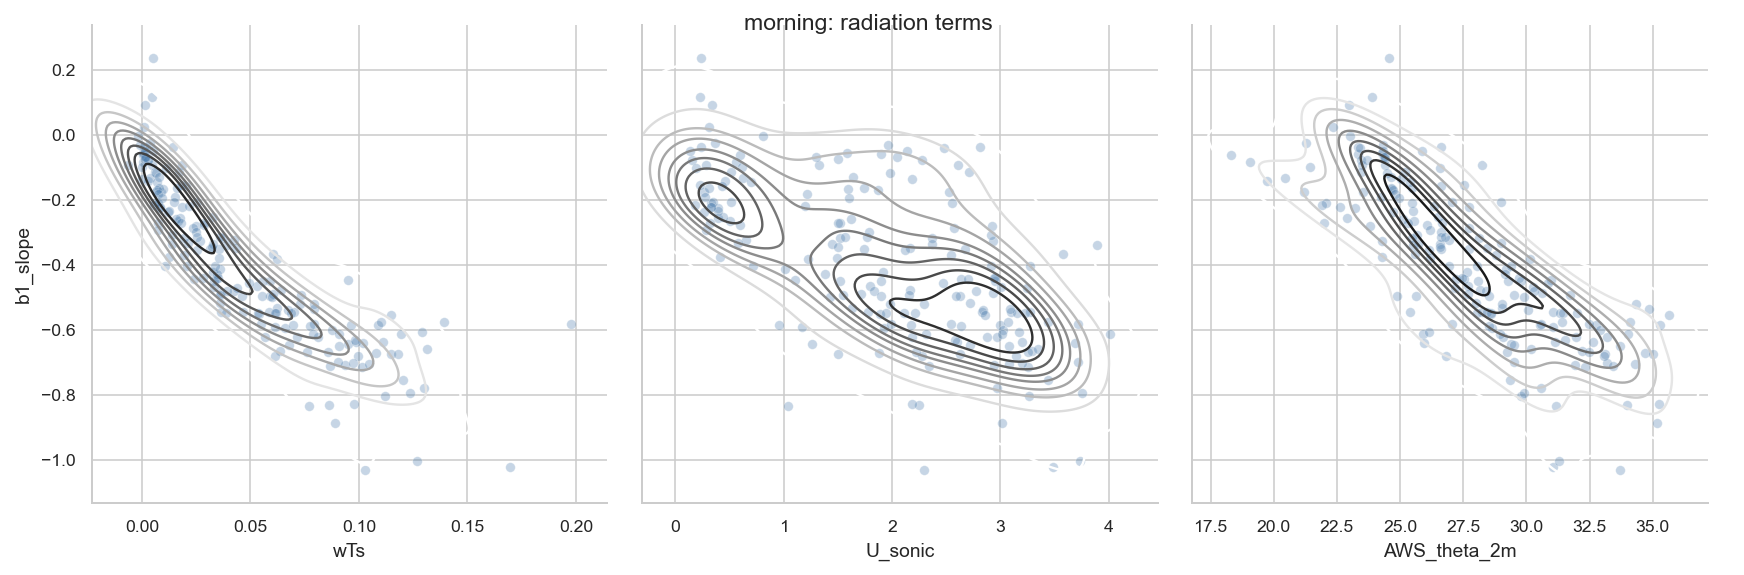

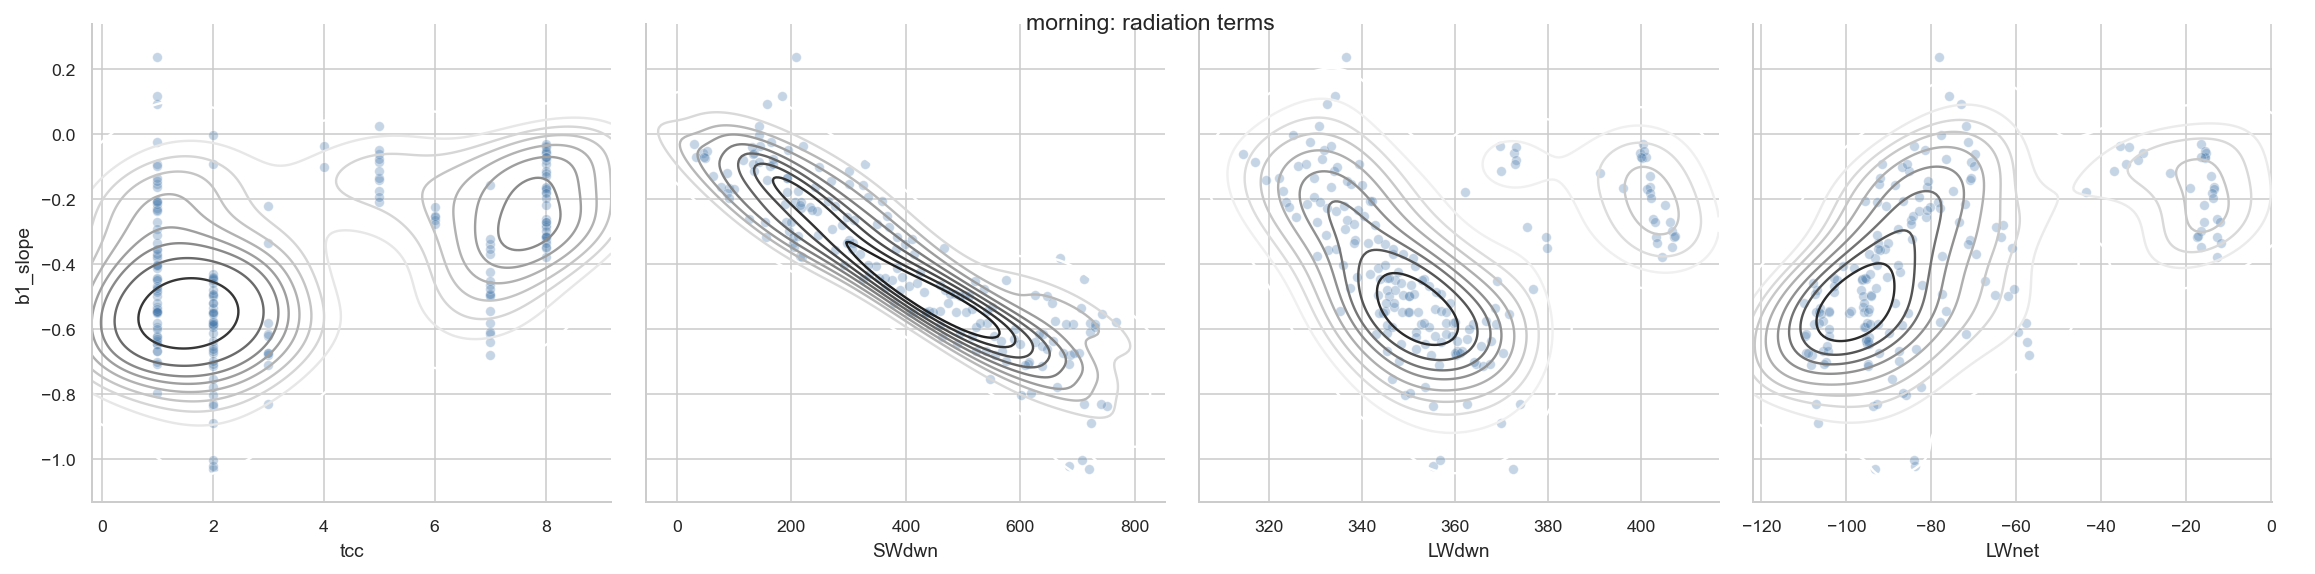

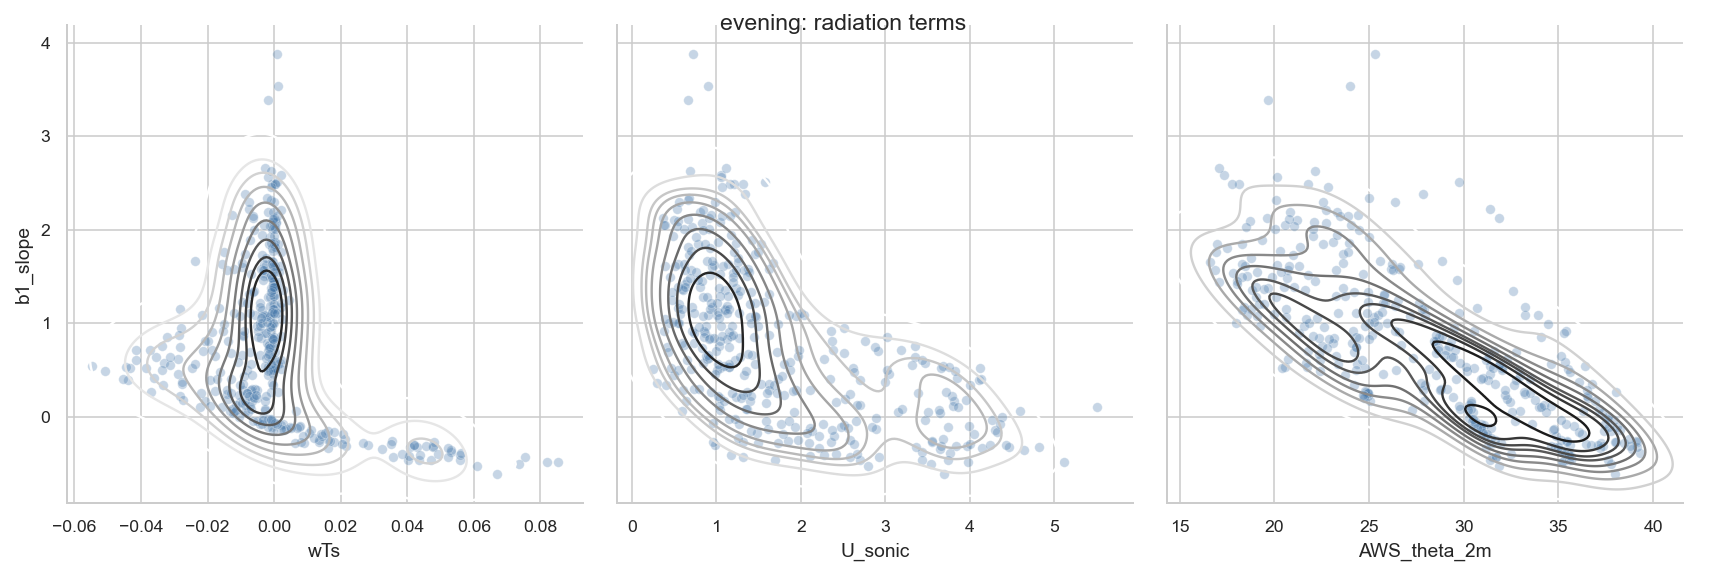

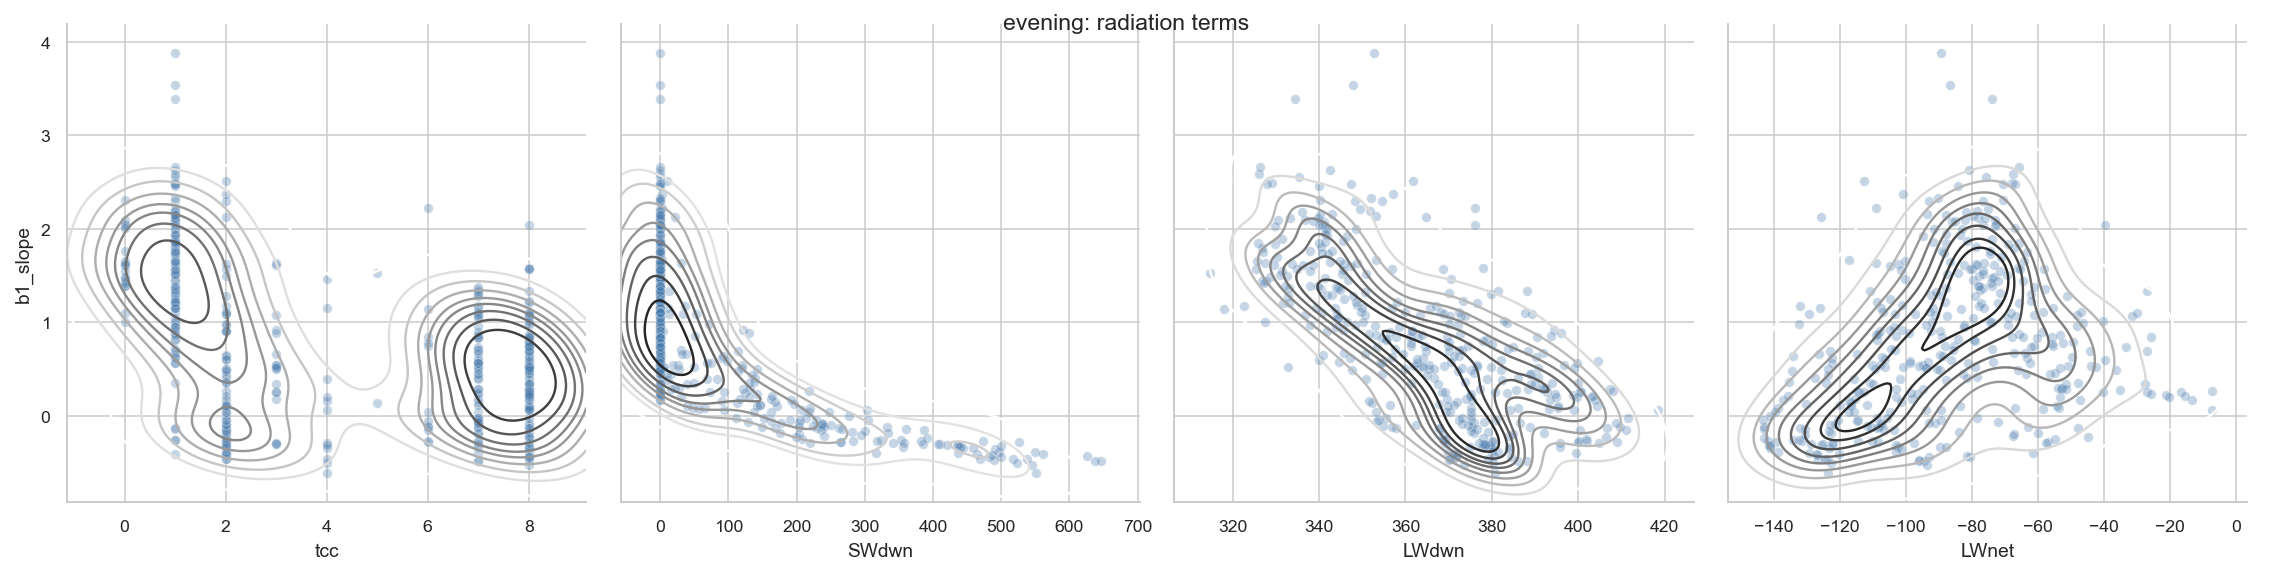

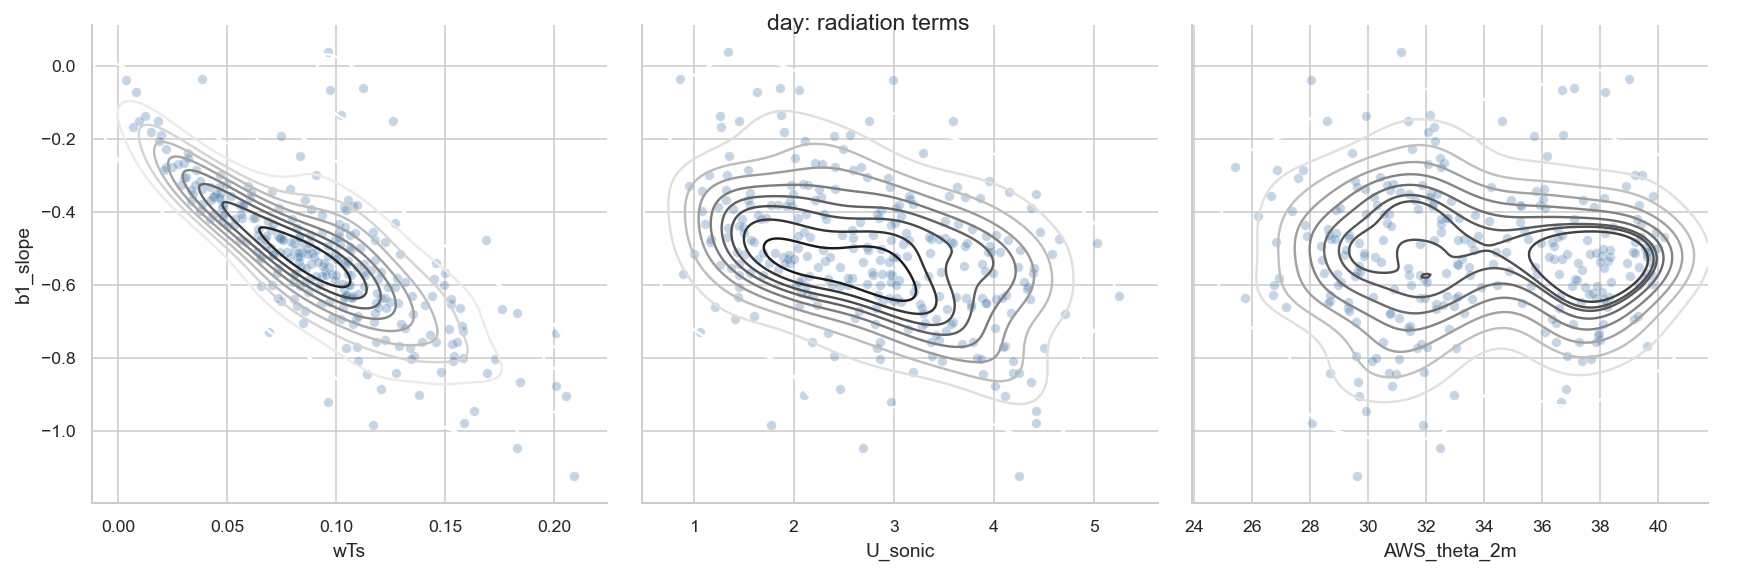

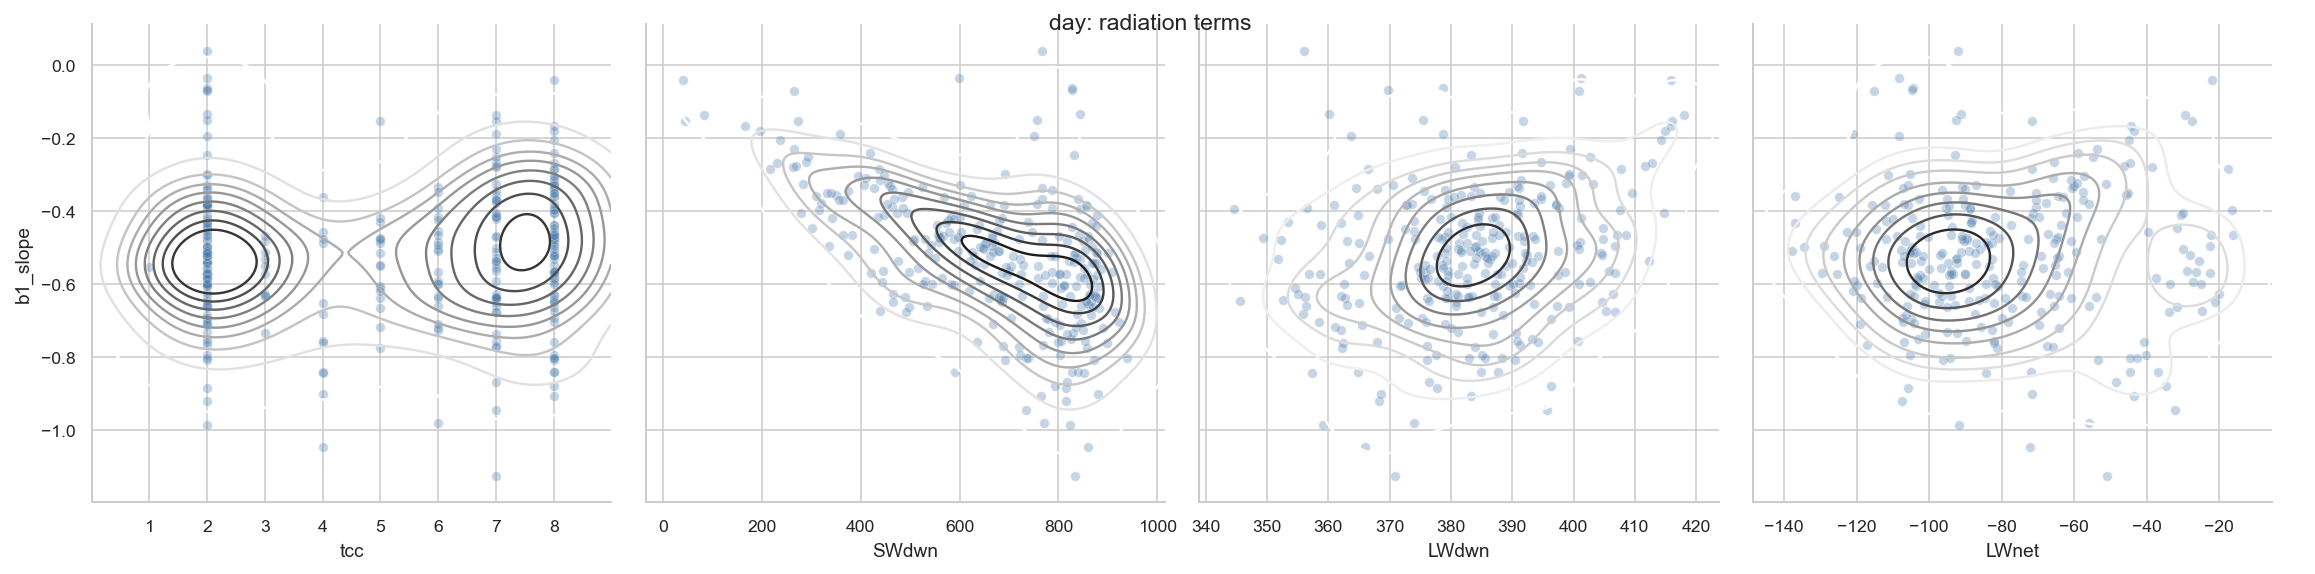

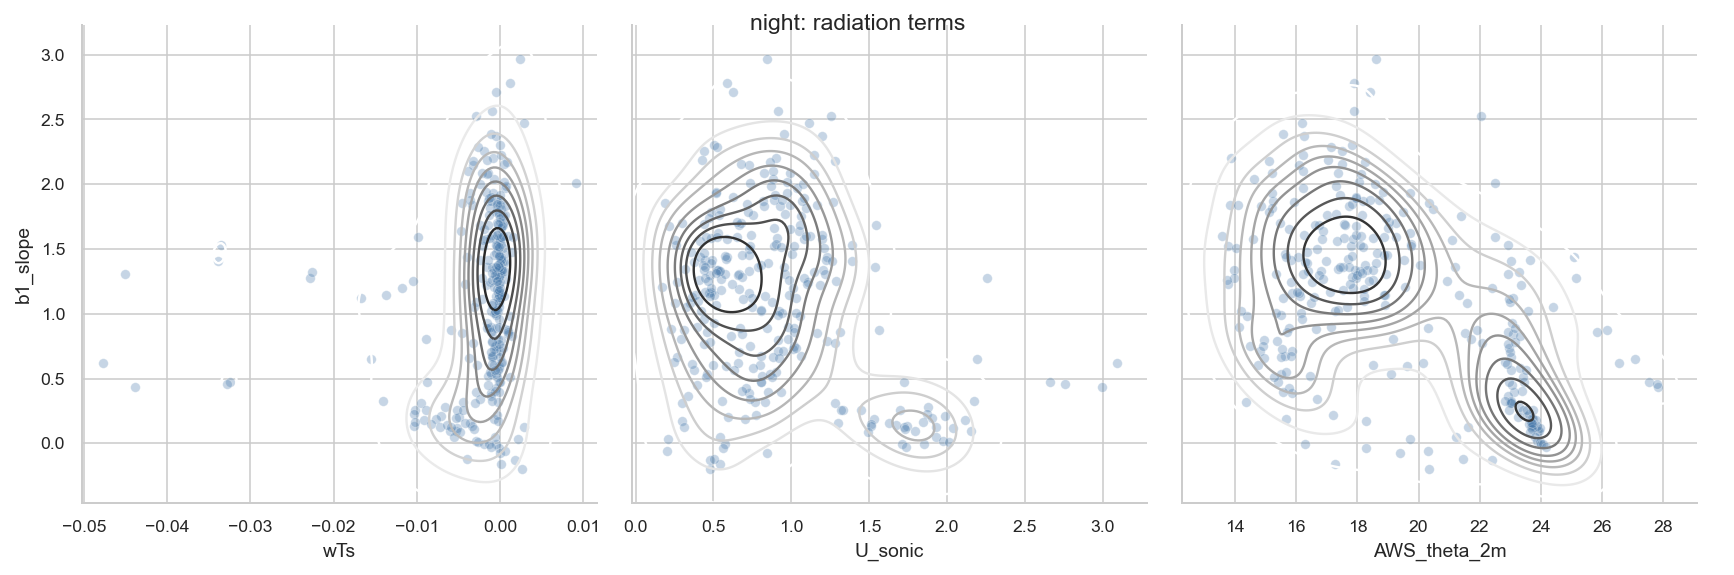

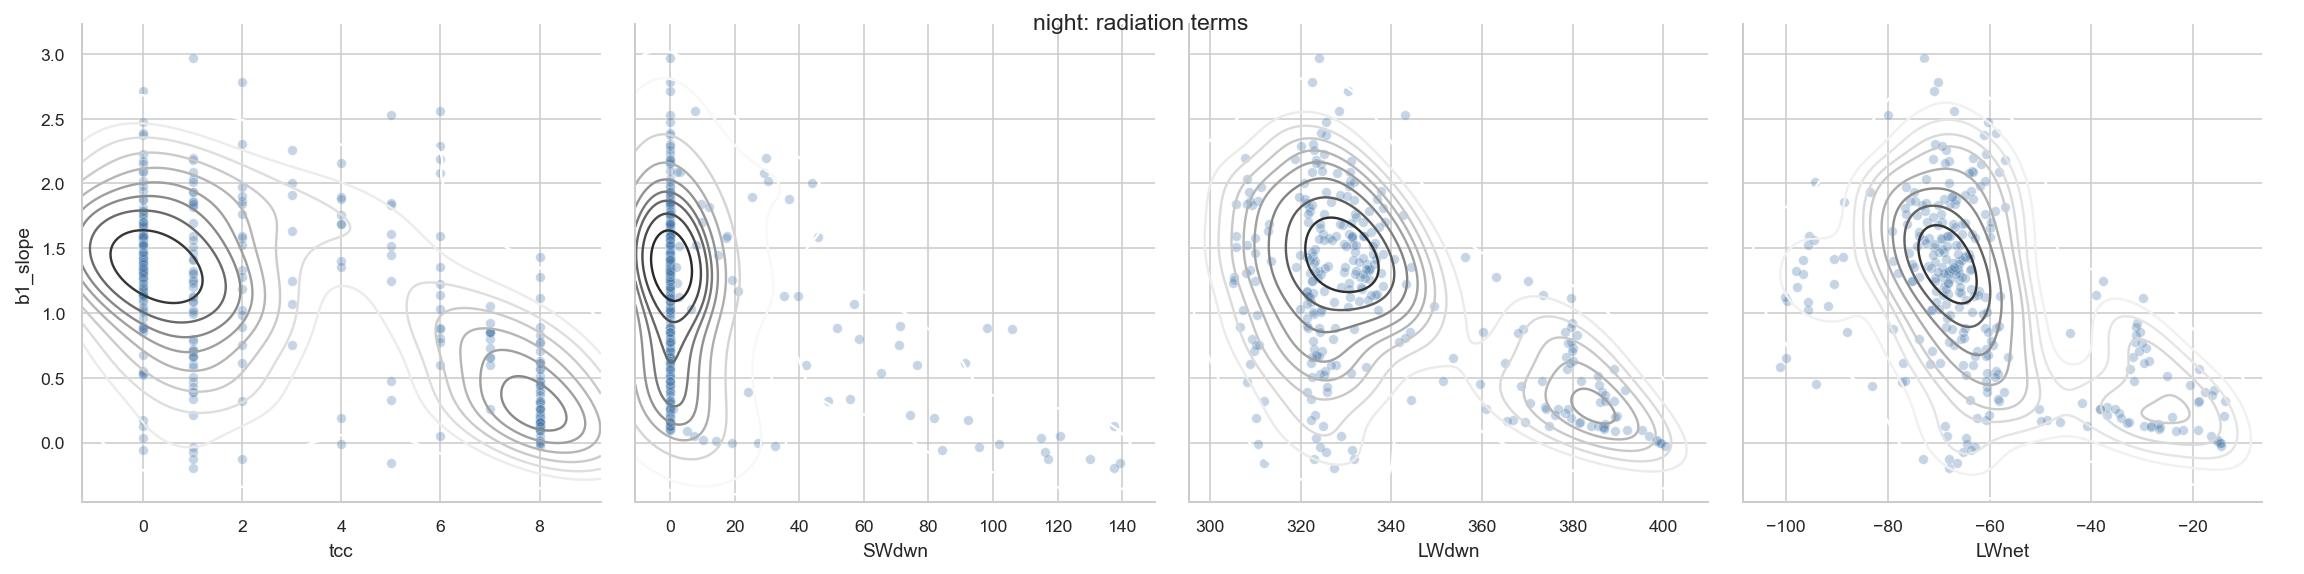

In [16]:
for interval in ['morning', 'evening', 'day', 'night']:
    # Turbulence terms
    g = sns.PairGrid(
        df_10min.where((df_10min.interval == interval)).loc['4m'],
        y_vars=["b1_slope"],
        x_vars=["wTs", "U_sonic", 'AWS_theta_2m'],
        height=4,
    )
    g.map(sns.kdeplot, cut=1, cmap="gray_r")
    g.map(sns.scatterplot, alpha=0.3)
    g.add_legend()
    plt.gcf().suptitle(interval + ': radiation terms')

    # Radiation terms
    g = sns.PairGrid(
        df_10min.where((df_10min.interval == interval)).loc['4m'],
        y_vars=["b1_slope"],
        x_vars=['tcc', 'SWdwn', 'LWdwn', 'LWnet'],
        height=4,
    )
    g.map(sns.kdeplot, cut=1, cmap="gray_r")
    g.map(sns.scatterplot, alpha=0.3)
    g.add_legend()
    plt.gcf().suptitle(interval + ': radiation terms')

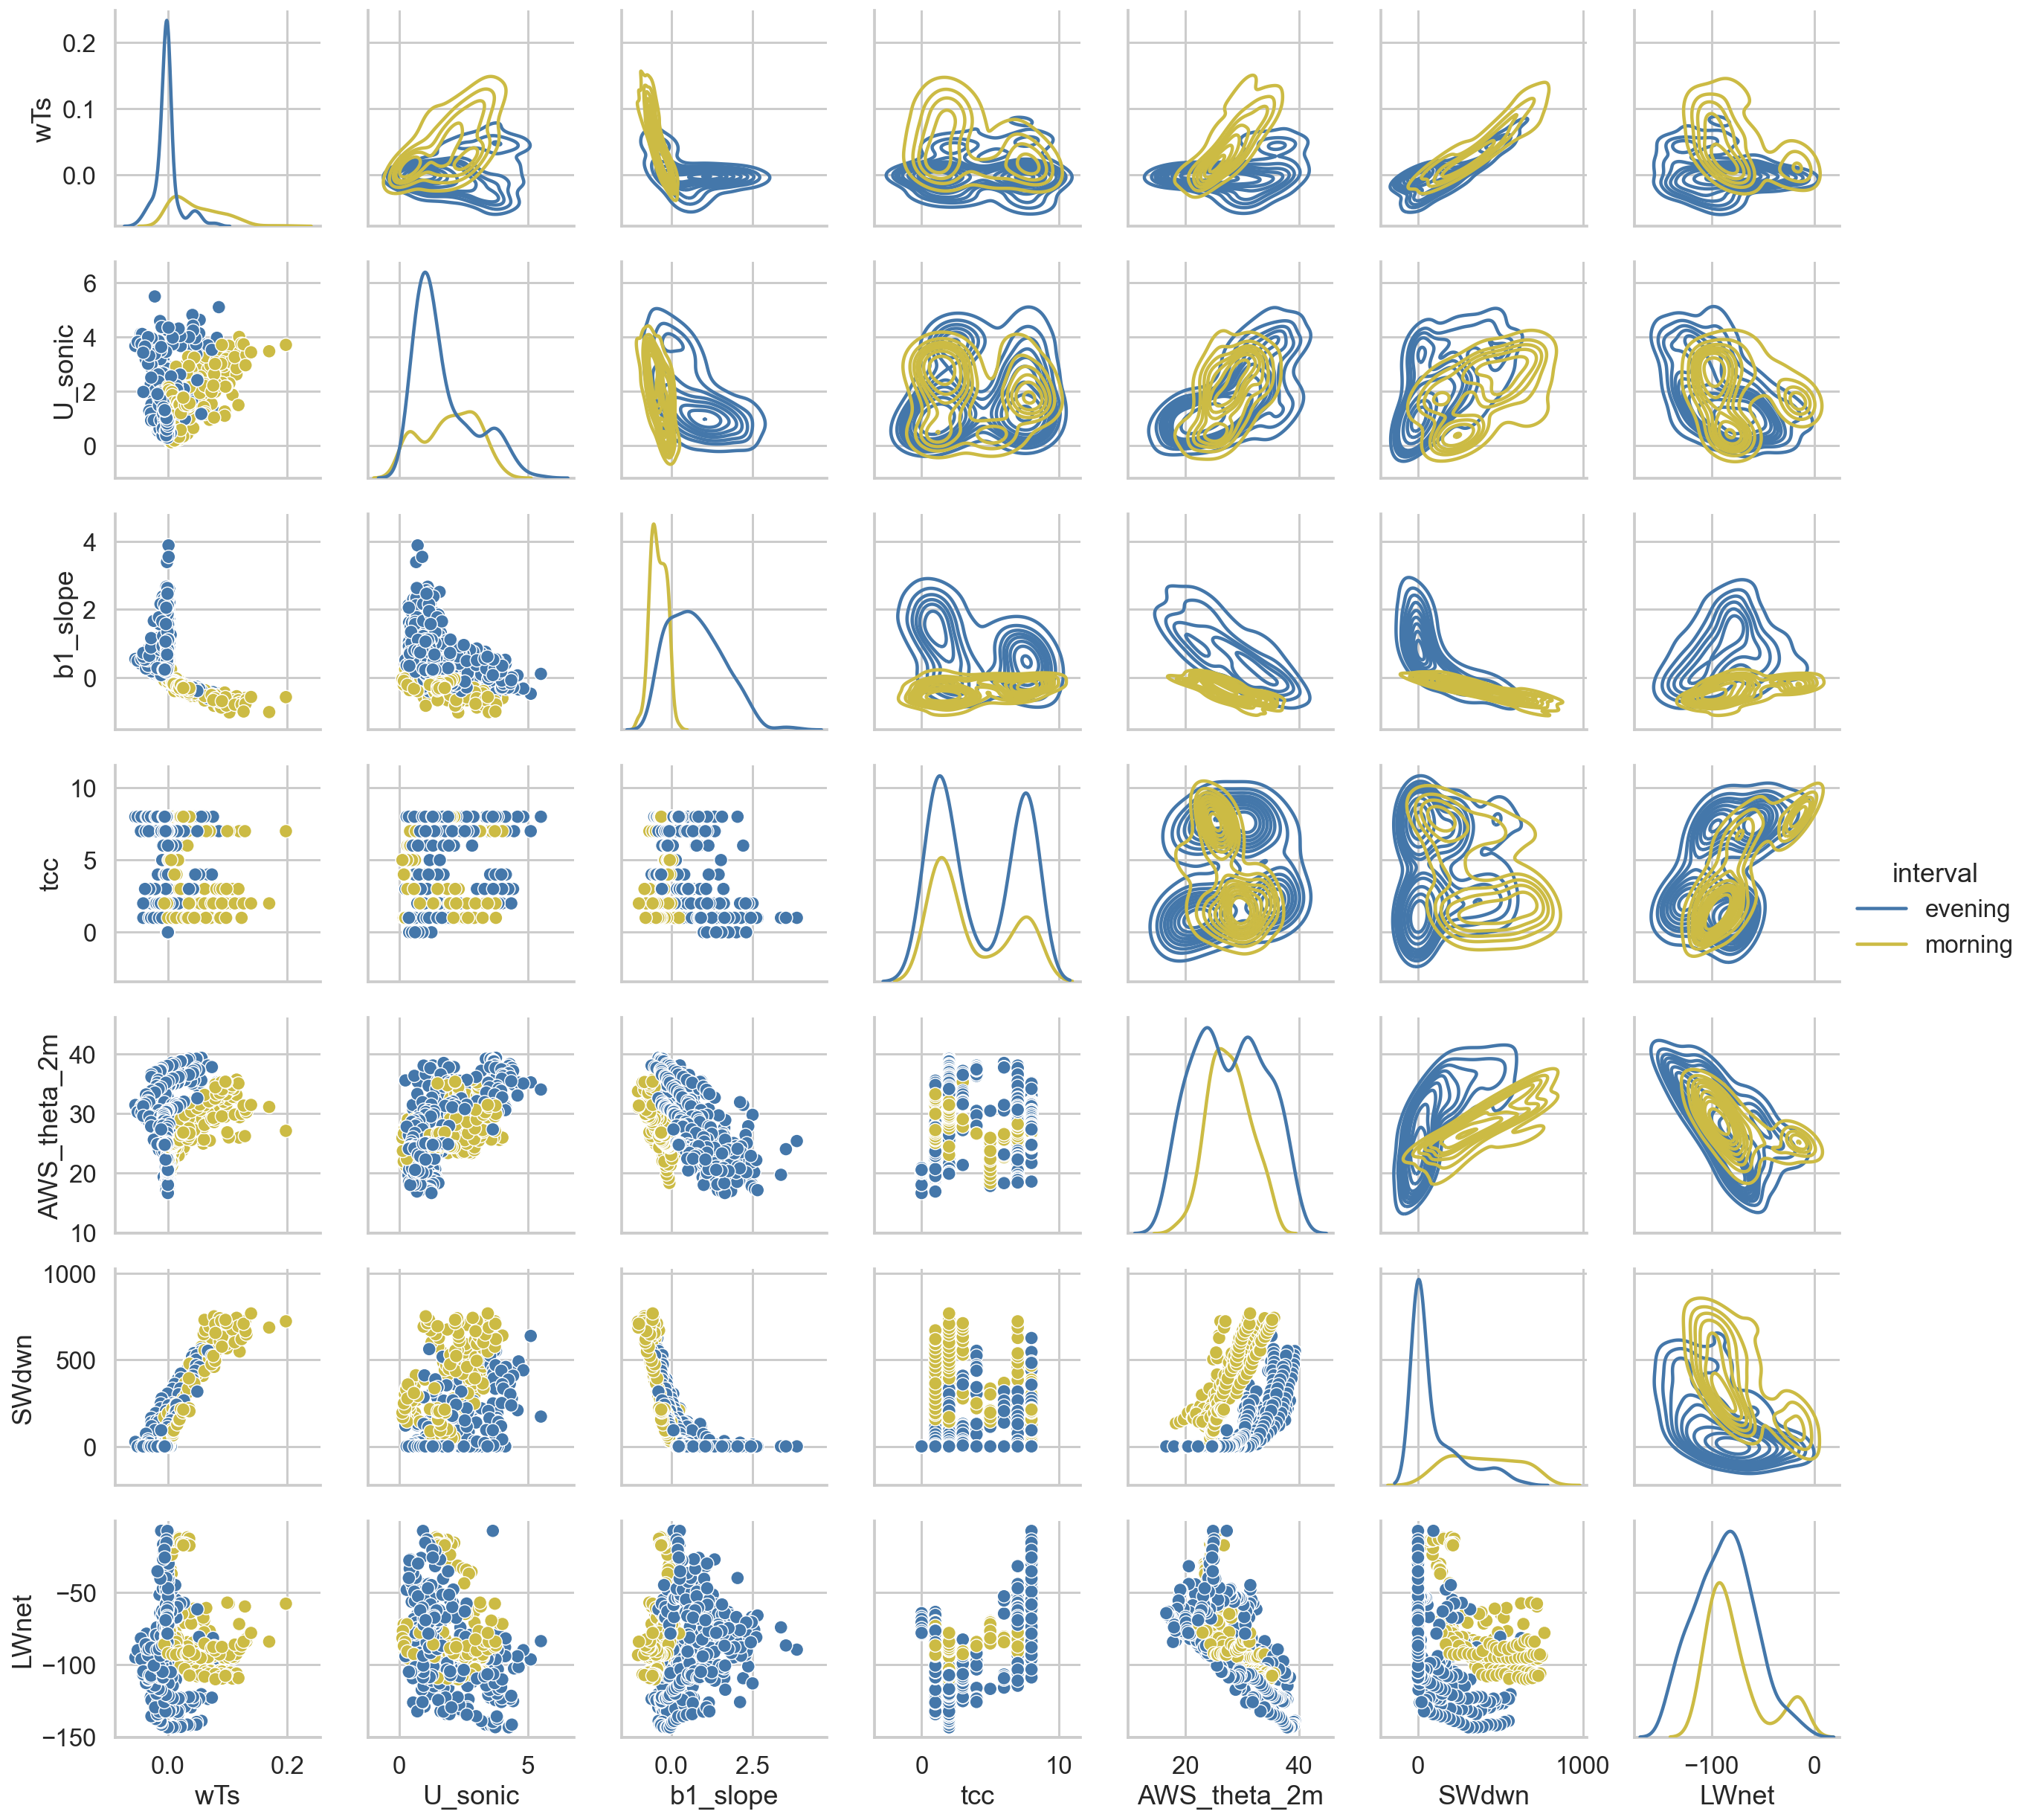

In [18]:
sns.set_context('talk')
grid = sns.PairGrid(
    df_10min.where((df_10min.interval == 'evening') | (df_10min.interval == 'morning')).loc['4m'],
    diag_sharey=False,
    hue='interval',
    vars=['wTs', 'U_sonic', 'b1_slope', 'tcc', 'AWS_theta_2m', 'SWdwn', 'LWnet'],
)

# Lower corner = scatter plots
glow = grid.map_lower(sns.scatterplot)
# Histograms on diagonal
gdiag = grid.map_diag(sns.kdeplot)
# Upper corner = KDE plots
gup = grid.map_upper(sns.kdeplot)
grid.add_legend()


To summarize some rather beefy figures, the log-linear slope tends to be more neutral when the wind speeds are larger, when the net longwave is very negative but some sunlight is present, when the difference between the AWS and tower at 2m is zero, when the potential temperature has not transitioned towards it day or night time values, and when the sensible heat flux is small (yay! That one is a necessity for believing the neutral boundary layer). However, there is a _lot_ of spread and co-occuring conditions for these categories.

# Next steps

There are obvious clusters to make here. These clusters may be powerful for correcting errors in the DTS temperatures and for understanding the impact of typical meteorological observations on the stability, which is a major research question in boundary layer meteorology.